In [149]:
from IPython.display import Image
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.estimators import HillClimbSearch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples,silhouette_score

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

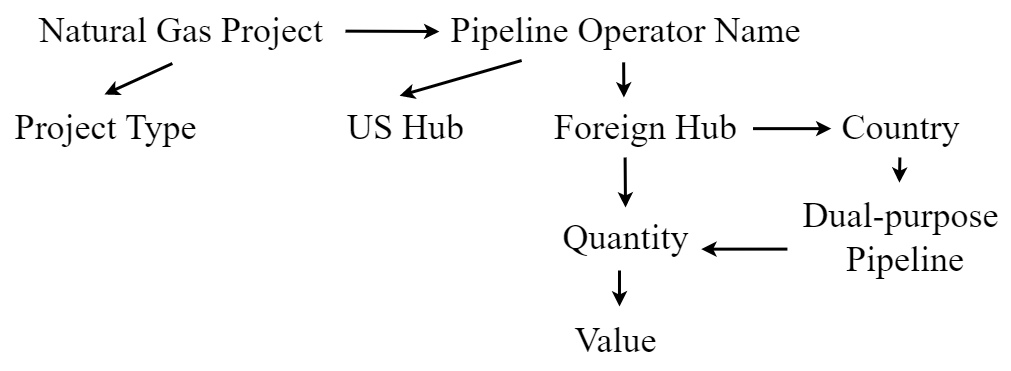

In [150]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Natural Gas Project, Value | Foreign Hub)? Independent  

CI (Natural Gas Project, Value | Pipeline Operator Name)?  Independent

CI (Foreign Hub, Dual-Purpose Pipeline | Country)? Independent

CI (Foreign Hub, Dual-Purpose Pipeline | Country, Value)? Dependent

2) Now consider a smaller dataset with only four discrete attributes (Pipeline Operator, US Hub, Foreign Hub, Value), and the following conditional probability distributions:

Pipeline Operator: YHVA (70%), PLMG (30%)

Foreign Hub | Pipeline Operator Name = YHVA: Mexico Northeast Region (40%), Mexico Central Region (60%)

Foreign Hub | Pipeline Operator Name = PLMG: Mexico Northeast Region (100%)

US Hub | Pipeline Operator Name = PLMG: US Hub (100%)

US Hub | Pipeline Operator Name = YHVA: US Hub (100%)

Quantity | Pipeline Operator Name = YHVA, Foreign Hub = Mexico Northeast Region: Natural Gas (95%), Hydrogen (5%)

Quantity | Pipeline Operator Name = PLMG, Foreign Hub = Mexico Northeast Region: Natural Gas (98%), Hydrogen (2%)

Quantity | Pipeline Operator Name = YHVA, Foreign Hub = Mexico Central Region: Natural Gas (96%), Hydrogen (4%)

Which of the following cases is most anomalous?

a) Natural gas transported from the Mexico Northeast Region to a US Hub by PLMG

b) Natural gas transported from the Mexico Northeast Region to a US Hub by YHVA

c) Hydrogen trasported from the Mexico Central Region to a US Hub by YHVA

To answer this question, compute the likelihood of each fuel (natural gas and hydrogen) given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

(Your answers here, including all calculations)  

a)p1=p(Pipeline Operator=PLMG)*p(Foreign Hub=Mexico Northeast Region|Pipeline Operator Name=PLMG)*p(US Hub | Pipeline Operator Name = PLMG)*p(Quantity=Natural gas | Pipeline Operator Name = PLMG, Foreign Hub = Mexico Northeast Region)=30%*100%*100%*98%=29.4%  

b)p2=p(Pipeline Operator=YHVA)*p(Foreign Hub=Mexico Northeast Region|Pipeline Operator Name=YHVA)*p(US Hub | Pipeline Operator Name = YHVA)*p(Quantity=Natural gas | Pipeline Operator Name = YHVA, Foreign Hub = Mexico Northeast Region)=70%*40%*100%*95%=26.6%  

c)p3=p(Pipeline Operator=YHVA)*p(Foreign Hub=Mexico Central Region|Pipeline Operator Name=YHVA)*p(US Hub | Pipeline Operator Name = YHVA)*p(Quantity=Hydrogen | Pipeline Operator Name = YHVA, Foreign Hub = Mexico Central Region)=70%60%*100%*4%=1.68%

Because 1.68%<26.6%<29.4%, c) Hydrogen trasported from the Mexico Central Region to a US Hub by YHVA is most anomalous.

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [151]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,1,0
2,1,0,1,1,1,1
3,1,0,0,1,1,1
4,2,1,0,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [152]:
# your answers here
#a)
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('C', 'A'), ('D', 'A'), ('F', 'A')]


In [153]:
#b)
best_model = BayesianNetwork([("C","A"),("D","A"),("F","A")])
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
    print(best_model.nodes)
for thenode in best_model.nodes():
    print(best_model.local_independencies(thenode))

CPD of C:
+------+--------+
| C(0) | 0.5015 |
+------+--------+
| C(1) | 0.4985 |
+------+--------+
['C', 'A', 'D', 'F']
CPD of A:
+------+----------------------+-----+----------------------+
| C    | C(0)                 | ... | C(1)                 |
+------+----------------------+-----+----------------------+
| D    | D(0)                 | ... | D(1)                 |
+------+----------------------+-----+----------------------+
| F    | F(0)                 | ... | F(1)                 |
+------+----------------------+-----+----------------------+
| A(0) | 0.4965893587994543   | ... | 0.001349527665317139 |
+------+----------------------+-----+----------------------+
| A(1) | 0.5006821282401092   | ... | 0.5033738191632928   |
+------+----------------------+-----+----------------------+
| A(2) | 0.001364256480218281 | ... | 0.4939271255060729   |
+------+----------------------+-----+----------------------+
| A(3) | 0.001364256480218281 | ... | 0.001349527665317139 |
+------+-------

In [154]:
#c)
test_x = test.loc[:,["C","D","F"]]
predicted_test = best_model.predict(test_x)
print("Out of sample:",(test.loc[:,'A'].reset_index(drop=True)==predicted_test['A']).mean())

  0%|          | 0/8 [00:00<?, ?it/s]

Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (10 pts).

c) **(Bonus)** Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (10 pts)  

d) **(Bonus)** Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (10 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (10 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [155]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [156]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


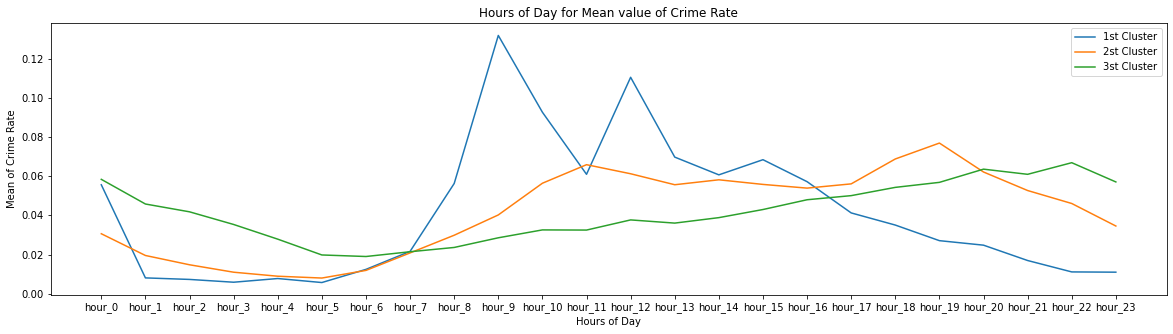

In [157]:
# your answers here
#a
Hours=np.array(data3[data3.columns[9:33]])
Kmeans=KMeans(n_clusters=3,random_state=20).fit(Hours)
data3['crime_label']=Kmeans.labels_
MeanHours=data3.groupby(['crime_label']).mean()[data3.columns[9:33]]
warnings.filterwarnings('ignore')
%matplotlib inline
fig=plt.figure(figsize=(20,5))
plt.plot(MeanHours.iloc[0],label='1st Cluster')
plt.plot(MeanHours.iloc[1],label='2st Cluster')
plt.plot(MeanHours.iloc[2],label='3st Cluster')
plt.legend()
plt.xlabel('Hours of Day')
plt.ylabel('Mean of Crime Rate')
plt.title('Hours of Day for Mean value of Crime Rate')
plt.show()

#b
In this line graph, we can see in 1st cluster, people commit a crime in the morning rather than in the evening, especially during 9am and 12pm. For the 2nd and 3rd cluster, it is more relatively stable than the 1st cluster. For all three clusters, people commit the crime is very low during early morning. But I think if I use more random state number, the results may affect and change.

In [158]:
#c
Crime=data3[['crime_label','crime_type']]
Crime['crime_type']=Crime.apply(lambda x:x['crime_type'].split(':')[0],axis=1)
Crime.head()

,crime_label,crime_type
0,2,ARSON
1,2,ASSAULT
2,2,ASSAULT
3,1,ASSAULT
4,2,ASSAULT


In [159]:
print(Crime[Crime['crime_label']==0].crime_type.value_counts(normalize=True))

DECEPTIVE PRACTICE        0.615385
OTHER OFFENSE             0.153846
ASSAULT                   0.076923
BATTERY                   0.076923
PUBLIC PEACE VIOLATION    0.076923
Name: crime_type, dtype: float64


In [160]:
print(Crime[Crime['crime_label']==1].crime_type.value_counts(normalize=True))

OTHER OFFENSE                       0.264151
NARCOTICS                           0.226415
THEFT                               0.132075
CRIMINAL TRESPASS                   0.056604
DECEPTIVE PRACTICE                  0.056604
OFFENSE INVOLVING CHILDREN          0.056604
ASSAULT                             0.037736
BATTERY                             0.037736
BURGLARY                            0.037736
GAMBLING                            0.018868
INTERFERENCE WITH PUBLIC OFFICER    0.018868
PUBLIC PEACE VIOLATION              0.018868
SEX OFFENSE                         0.018868
WEAPONS VIOLATION                   0.018868
Name: crime_type, dtype: float64


In [161]:
print(Crime[Crime['crime_label']==2].crime_type.value_counts(normalize=True))

BATTERY                             0.188679
ROBBERY                             0.169811
CRIMINAL DAMAGE                     0.094340
ASSAULT                             0.075472
WEAPONS VIOLATION                   0.056604
MOTOR VEHICLE THEFT                 0.056604
NARCOTICS                           0.056604
BURGLARY                            0.037736
CRIM SEXUAL ASSAULT                 0.037736
SEX OFFENSE                         0.037736
OTHER OFFENSE                       0.018868
STALKING                            0.018868
PROSTITUTION                        0.018868
ARSON                               0.018868
OFFENSE INVOLVING CHILDREN          0.018868
INTERFERENCE WITH PUBLIC OFFICER    0.018868
HOMICIDE                            0.018868
DECEPTIVE PRACTICE                  0.018868
CRIMINAL TRESPASS                   0.018868
LIQUOR LAW VIOLATION                0.018868
Name: crime_type, dtype: float64


As the results, the first cluster has a lot of deceptive practice, second cluster main crimes are other offense and narcotics, and the third cluster main crimes are battery and robbery.

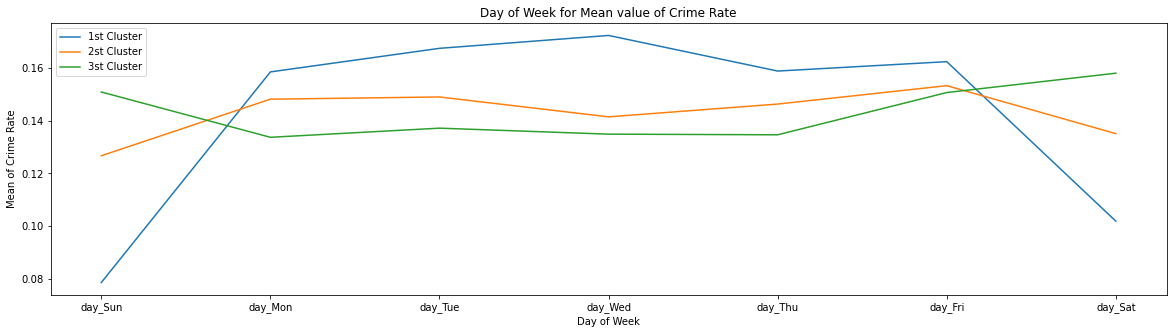

In [162]:
#d
day_of_week=data3.iloc[:,[2,3,4,5,6,7,8,110]]
Mean_of_dayweek=day_of_week.groupby(['crime_label']).mean()
fig=plt.figure(figsize=(20,5))
plt.plot(Mean_of_dayweek.iloc[0],label='1st Cluster')
plt.plot(Mean_of_dayweek.iloc[1],label='2st Cluster')
plt.plot(Mean_of_dayweek.iloc[2],label='3st Cluster')
plt.legend()
plt.xlabel('Day of Week')
plt.ylabel('Mean of Crime Rate')
plt.title('Day of Week for Mean value of Crime Rate')
plt.show()

As the results show, yes, three clusters have different day-of-week trends. The first cluster has high rate of crime during the weekdays, and low during the weekends. the other two cluster are more stable.

In [163]:
#e method 1
Crime_community=data3.loc[:,'community_area_1':'crime_label']
Mean_of_Community=Crime_community.groupby(['crime_label']).mean()
Mean_of_Community

,community_area_1,community_area_2,community_area_3,community_area_4,community_area_5,community_area_6,community_area_7,community_area_8,community_area_9,community_area_10,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
crime_label,,,,,,,,,,,,,,,,,,,,,
0,0.012528,0.013536,0.017650,0.011505,0.010555,0.028760,0.019447,0.054875,0.002423,0.008024,...,0.019251,0.017245,0.012690,0.022950,0.005480,0.010236,0.003683,0.010348,0.011947,0.013122
1,0.012591,0.010208,0.012409,0.006358,0.002986,0.016960,0.009671,0.031548,0.000990,0.003776,...,0.028041,0.027521,0.005594,0.029390,0.002722,0.012186,0.002132,0.007710,0.012571,0.006738
2,0.013562,0.012788,0.012691,0.006845,0.004130,0.018801,0.008871,0.024736,0.000582,0.003383,...,0.027000,0.028354,0.009691,0.029029,0.002729,0.010119,0.001482,0.006931,0.003044,0.006753


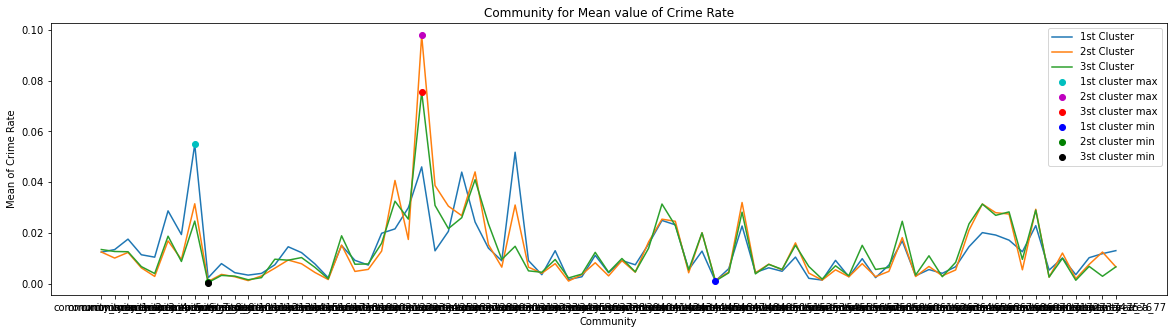

In [164]:
fig=plt.figure(figsize=(20,5))
plt.plot(Mean_of_Community.iloc[0],label='1st Cluster')
plt.plot(Mean_of_Community.iloc[1],label='2st Cluster')
plt.plot(Mean_of_Community.iloc[2],label='3st Cluster')
#get max value
max1=plt.plot(Mean_of_Community.iloc[0].idxmax(),max(Mean_of_Community.iloc[0]),'co',label="1st cluster max")
max2=plt.plot(Mean_of_Community.iloc[1].idxmax(),max(Mean_of_Community.iloc[1]),'mo',label="2st cluster max")
max3=plt.plot(Mean_of_Community.iloc[2].idxmax(),max(Mean_of_Community.iloc[2]),'ro',label="3st cluster max")
#get min value
min1=plt.plot(Mean_of_Community.iloc[0].idxmin(),min(Mean_of_Community.iloc[0]),'bo',label="1st cluster min")
min2=plt.plot(Mean_of_Community.iloc[1].idxmin(),min(Mean_of_Community.iloc[1]),'go',label="2st cluster min")
min3=plt.plot(Mean_of_Community.iloc[2].idxmin(),min(Mean_of_Community.iloc[2]),'ko',label="3st cluster min")
plt.legend()
plt.xlabel('Community')
plt.ylabel('Mean of Crime Rate')
plt.title('Community for Mean value of Crime Rate')
plt.show()

In [165]:
print(Mean_of_Community.iloc[0].max())
print(Mean_of_Community.iloc[1].max())
print(Mean_of_Community.iloc[2].max())
Mean_of_Community.idxmax(axis=1)

0.05487494723076924
0.09772091041509433
0.07546586305660377


crime_label
0     community_area_8
1    community_area_25
2    community_area_25
dtype: object

In [180]:
data4.loc[(data4['Community Area Number']==8)|(data4['Community Area Number']==25)]

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016,label
7,8,Near North Side,1175512.220,1906089.147,1.9,12.9,7.0,2.5,22.6,88669,17.077160,9847,1
24,25,Austin,1140839.462,1903174.321,6.3,28.6,22.6,24.4,37.9,15957,14.188517,15719,2


Yes, the three clusters affect different types of communities/neighborhoods. The community 8 is the richest area and community 25 is the poorest. Percent of Housing Crowded, Percent households below poverty, Percent aged 16+ unemployed,etc are higher than average in community 25.

In [167]:
#method2
crimes=data3.groupby(['crime_label'],as_index=False).mean()[data3.columns[33:109]].T.reset_index()
crimes['Community']=crimes.apply(lambda x:x['index'].split('_')[2],axis=1)
crimes.rename(columns={0:'1st cluster',1:'2nd cluster',2:'3rd cluster'},inplace=True)
crimes=crimes[['1st cluster','2nd cluster','3rd cluster','Community']]
crimes['Community']=crimes['Community'].astype('int')
crimes_community=crimes.merge(data4,left_on='Community',right_on='Community Area Number')
crimes_community

,1st cluster,2nd cluster,3rd cluster,Community,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,0.012528,0.012591,0.013562,1,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,0.013536,0.010208,0.012788,2,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,0.017650,0.012409,0.012691,3,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,0.011505,0.006358,0.006845,4,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,0.010555,0.002986,0.004130,5,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.005480,0.002722,0.002729,72,72,Beverly,1164529.216,1838321.860,0.9,5.1,8.0,3.7,40.5,39523,4.662034,911
72,0.010236,0.012186,0.010119,73,73,Washington Height,1170876.014,1841023.256,1.1,16.9,20.8,13.7,42.6,19713,8.519055,3029
73,0.003683,0.002132,0.001482,74,74,Mount Greenwood,1154848.722,1832033.633,1.0,3.4,8.7,4.3,36.8,34381,5.207486,561
74,0.010348,0.007710,0.006931,75,75,Morgan Park,1167279.655,1830138.284,0.8,13.2,15.0,10.8,40.3,27149,8.606832,1853


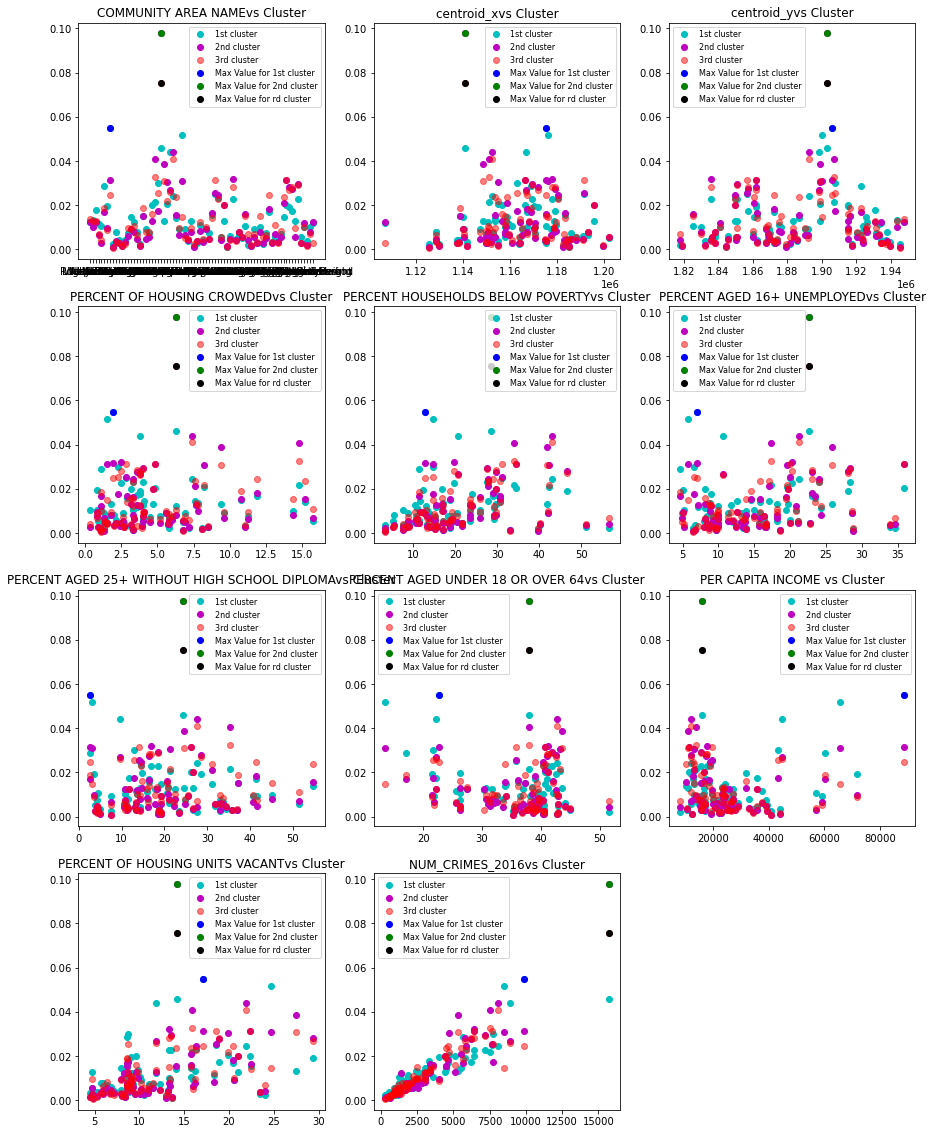

In [168]:
Max1=crimes.nlargest(1,'1st cluster')[['Community','1st cluster']]
Max1=Max1.merge(data4,left_on='Community',right_on='Community Area Number')
Max2=crimes.nlargest(1,'2nd cluster')[['Community','2nd cluster']]
Max2=Max2.merge(data4, left_on='Community',right_on='Community Area Number')
Max3=crimes.nlargest(1,'3rd cluster')[['Community','3rd cluster']]
Max3=Max3.merge(data4,left_on='Community',right_on='Community Area Number')
fig=plt.figure(figsize=(15,20))
for a,b in enumerate(crimes_community.columns[5:]):
    ax=fig.add_subplot(4,3,a+1)
    ax.set_title(str(b)+'vs Cluster')
    ax.plot(crimes_community[b], crimes_community['1st cluster'],'co',label='1st cluster')
    ax.plot(crimes_community[b], crimes_community['2nd cluster'],'mo',label='2nd cluster')
    ax.plot(crimes_community[b], crimes_community['3rd cluster'],'ro', alpha=0.5,label='3rd cluster')
    ax.plot(Max1[b], Max1['1st cluster'],'bo',label='Max Value for 1st cluster')
    ax.plot(Max2[b], Max2['2nd cluster'],'go',label='Max Value for 2nd cluster')
    ax.plot(Max3[b], Max3['3rd cluster'],'ko',label='Max Value for rd cluster')
    ax.legend(fontsize=8)

The results is same and we can clearly see the max value of each community in each cluster.

In [169]:
#f
Hours_division=data3[['Category','crime_label']]
print(Hours_division[Hours_division['crime_label']==0].Category.value_counts(normalize=True))

P2    1.0
Name: Category, dtype: float64


In [170]:
print(Hours_division[Hours_division['crime_label']==1].Category.value_counts(normalize=True))

P2     0.792453
P1P    0.169811
P1V    0.037736
Name: Category, dtype: float64


In [171]:
print(Hours_division[Hours_division['crime_label']==2].Category.value_counts(normalize=True))

P2     0.471698
P1V    0.415094
P1P    0.113208
Name: Category, dtype: float64


In [172]:
data4=pd.read_csv("HW3Q3_2.csv")
Hours_new=np.array(data4[data4.columns[4:12]])
Kmeans=KMeans(n_clusters=3,random_state=20).fit(Hours_new)
data4['label']=Kmeans.labels_
crime_community1=crimes.merge(data4,left_on='Community',right_on='Community Area Number')
division=crime_community1[['1st cluster','2nd cluster','3rd cluster','label']]
division.groupby(['label']).mean()

,1st cluster,2nd cluster,3rd cluster
label,,,
0,0.010903,0.007012,0.007307
1,0.029110,0.016477,0.012758
2,0.011903,0.015248,0.015577


We have P2 in the first cluster. most P2 and few P1P and P1V in the second cluster. Half P2 and P1V in the third cluster. In the chart, the first cluster has high proportation in label 0.

In [182]:
#g
#kmeans
daysweek=np.array(data3[data3.columns[2:9]])
for n_clusters in range(2,15):
    Kmeans=KMeans(n_clusters=n_clusters,random_state=20).fit(daysweek)
    clusterlabels=Kmeans.labels_
    score=silhouette_score(daysweek,clusterlabels,metric='euclidean',sample_size=None,random_state=None)
    print(n_clusters,'clusters, the silhouette score is:',score)

2 clusters, the silhouette score is: 0.236530390685153
3 clusters, the silhouette score is: 0.2179643975075137
4 clusters, the silhouette score is: 0.22478470015985164
5 clusters, the silhouette score is: 0.24427904153334734
6 clusters, the silhouette score is: 0.18371376895107863
7 clusters, the silhouette score is: 0.16646682355570047
8 clusters, the silhouette score is: 0.1637747858603285
9 clusters, the silhouette score is: 0.16741934001312334
10 clusters, the silhouette score is: 0.1423403065749694
11 clusters, the silhouette score is: 0.17506323631448648
12 clusters, the silhouette score is: 0.16575406139157042
13 clusters, the silhouette score is: 0.14740276710639688
14 clusters, the silhouette score is: 0.15376511867245643


Cluster 6 has the highest silhouette score.

In [174]:
#Gaussian mixture models
cluster_num={}
for n_clusters in range(2,10):
    GM=GaussianMixture(n_components=n_clusters,random_state=20)
    clusterlabels=GM.fit_predict(daysweek)
    score=silhouette_score(daysweek,clusterlabels)
    print(n_clusters,'clusters, the silhouette score is:',score)
    cluster_num[n_clusters]=score

2 clusters, the silhouette score is: 0.2567272675700467
3 clusters, the silhouette score is: 0.22735540612194638
4 clusters, the silhouette score is: 0.22096855848132832
5 clusters, the silhouette score is: 0.12963982060567583
6 clusters, the silhouette score is: 0.1895154397895
7 clusters, the silhouette score is: 0.10461005398024655
8 clusters, the silhouette score is: 0.17820664124504002
9 clusters, the silhouette score is: 0.17246797330033795


Both Kmeans and Gaussian mixture models are assign points to each clusters. Gaussian mixture models returns the probability of assign the point to each cluster, similar as Kmeans.

In [175]:
#Bottom-up hierarchical (single-link)
for n_clusters in range(2,10):
    Hierarchical_Single = AgglomerativeClustering(n_clusters=n_clusters,linkage='single').fit(daysweek)
    clusterlabels=Hierarchical_Single.fit_predict(daysweek)
    score=silhouette_score(daysweek,clusterlabels,metric='euclidean')
    print(n_clusters,'clusters, the silhouette score is:',score)

2 clusters, the silhouette score is: 0.6377648080667614
3 clusters, the silhouette score is: 0.5568477382969329
4 clusters, the silhouette score is: 0.40557775075981556
5 clusters, the silhouette score is: 0.38770381887486693
6 clusters, the silhouette score is: 0.390076195102219
7 clusters, the silhouette score is: 0.34621844820394365
8 clusters, the silhouette score is: 0.32899815764355894
9 clusters, the silhouette score is: 0.3254219274892414


Cluster 2 has highest silhouette score, so we pick the cluster 2 for the prediction.

In [176]:
#Bottom-up hierarchical (complete-link)
for n_clusters in range(2,10):
    Hierarchical_Complete=AgglomerativeClustering(n_clusters=n_clusters,linkage='complete').fit(daysweek)
    clusterlabels=Hierarchical_Complete.fit_predict(daysweek)
    score=silhouette_score(daysweek,clusterlabels,metric='euclidean')
    print(n_clusters,'clusters, the silhouette score is:',score)

2 clusters, the silhouette score is: 0.6100646113547025
3 clusters, the silhouette score is: 0.17268718146566114
4 clusters, the silhouette score is: 0.1921516937476861
5 clusters, the silhouette score is: 0.15025207822499773
6 clusters, the silhouette score is: 0.15229681572228085
7 clusters, the silhouette score is: 0.14926267616109443
8 clusters, the silhouette score is: 0.10130440123428042
9 clusters, the silhouette score is: 0.10066503899164776


Same as single link for bottom-up hierarchical, pick the highest silhouette score 2 clusters for the prediction which means these two methods has better classified appropriatety for each objects because we did not prune out the link.